# LSTM Recurrent Neural Network For Stock Market Prediction

## NB: make sure you install "nsepy"
## A library to extract historical and realtime data from NSE’s website. This Library aims to keep the API very simple

### 1.Import the required libraries

In [1]:
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


### Historical prices of SBIN from 01.01.2013 to 15-02-2022.

In [3]:
start = dt.datetime(2013,1,1)
end = dt.datetime(2022,2,15)
stk_data = gh(symbol='SBIN',start=start,end=end)


### 3. We can visualise the fetched data in the above step. For simplicity, only the day-wise closing prices are visualised.


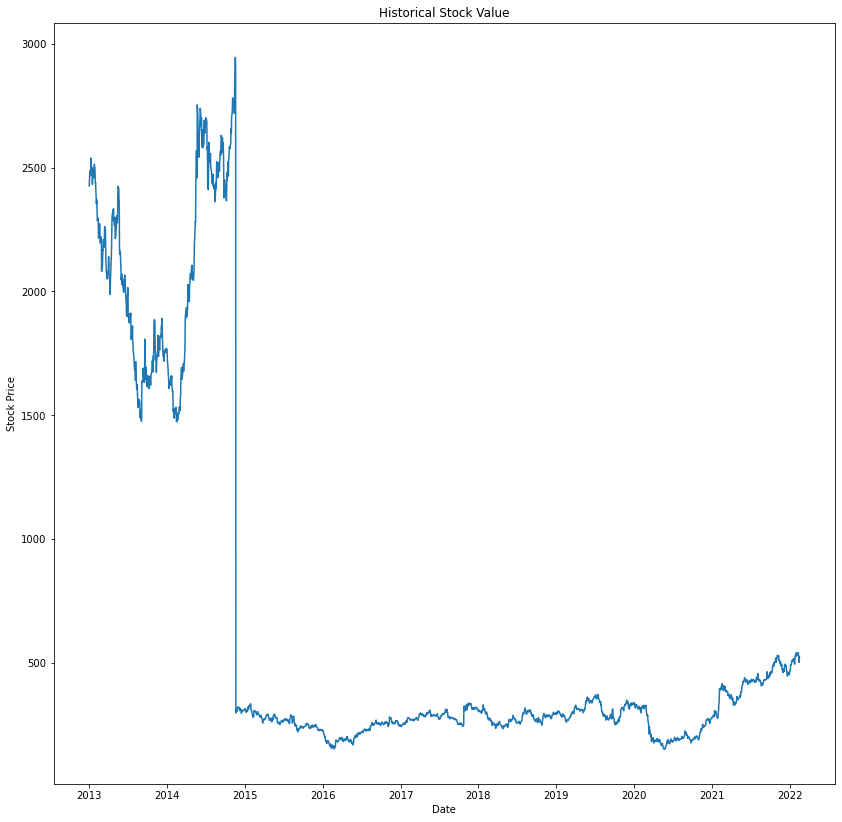

In [4]:
plt.figure(figsize=(14,14))
plt.plot(stk_data['Close'])
plt.title('Historical Stock Value')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


### 4. There are 12 columns in the fetched data. Many of the columns are not of our interest so only significant columns are selected to create the main dataset.

In [5]:
stk_data['Date'] = stk_data.index
data2 = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
data2['Date'] = stk_data['Date']
data2['Open'] = stk_data['Open']
data2['High'] = stk_data['High']
data2['Low'] = stk_data['Low']
data2['Close'] = stk_data['Close']


### 5. Preprocess the data in order to prepare it for the LSTM model. The data fetched in step one is used for training purpose only. For testing purpose, different data will be fetched later.

In [6]:
train_set = data2.iloc[:, 1:2].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(train_set)
X_train = []
y_train = []
for i in range(60, 1482):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


### 6. Define the LSTM Recurrent Neural Network. Here, you can add more LSTM layers and adjust the dropout in order to improve the accuracy of the model.

In [7]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))


### 7. Compile and train the model defined in the above step. Iteratively, you can increase or decrease the epochs and batch size to get more accuracy.

In [8]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs = 15, batch_size = 32)


Epoch 1/15
45/45 [==============================] - 18s 124ms/step - loss: 0.0228
Epoch 2/15
45/45 [==============================] - 5s 109ms/step - loss: 0.0087
Epoch 3/15
45/45 [==============================] - 6s 126ms/step - loss: 0.0074
Epoch 4/15
45/45 [==============================] - 5s 119ms/step - loss: 0.0072
Epoch 5/15
45/45 [==============================] - 6s 123ms/step - loss: 0.0064
Epoch 6/15
45/45 [==============================] - 6s 144ms/step - loss: 0.0059
Epoch 7/15
45/45 [==============================] - 6s 138ms/step - loss: 0.0062
Epoch 8/15
45/45 [==============================] - 6s 135ms/step - loss: 0.0054
Epoch 9/15
45/45 [==============================] - 6s 124ms/step - loss: 0.0053
Epoch 10/15
45/45 [==============================] - 5s 112ms/step - loss: 0.0056
Epoch 11/15
45/45 [==============================] - 6s 127ms/step - loss: 0.0043
Epoch 12/15
45/45 [==============================] - 6s 137ms/step - loss: 0.0054
Epoch 13/15
45/45 [=====

### 8. Now, our model is trained and needs to be tested on the testing data. For this purpose, fetch the new data for a different period. Preprocessing steps are similar as we have done with training data.

In [9]:
testdataframe= gh(symbol='SBIN',start=dt.datetime(2019,1,1),end=dt.datetime(2019,9,18))
testdataframe['Date'] = testdataframe.index
testdata = pd.DataFrame(columns = ['Date', 'Open', 'High', 'Low', 'Close'])
testdata['Date'] = testdataframe['Date']
testdata['Open'] = testdataframe['Open']
testdata['High'] = testdataframe['High']
testdata['Low'] = testdataframe['Low']
testdata['Close'] = testdataframe['Close']
real_stock_price = testdata.iloc[:, 1:2].values
dataset_total = pd.concat((data2['Open'], testdata['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(testdata) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 235):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


### 9. Test the LSTM model on the new dataset.

In [10]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


### 10. Visualize the predicted stock prices with original stock prices.

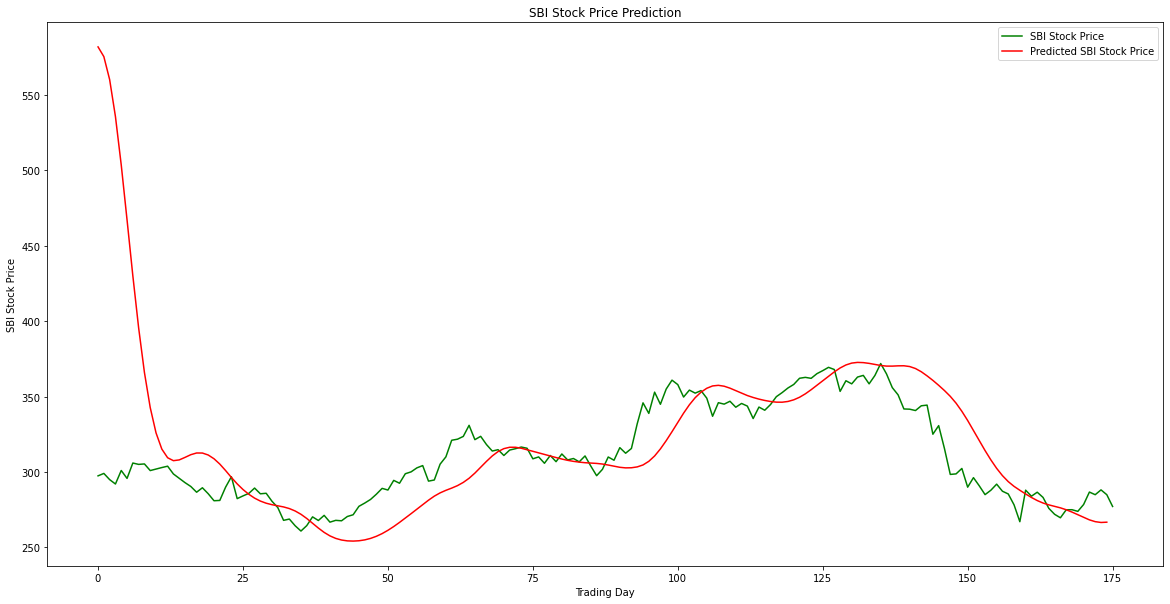

In [11]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'SBI Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted SBI Stock Price')
plt.title('SBI Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('SBI Stock Price')
plt.legend()
plt.show()
